In [22]:
import pandas as pd
import geopandas
import geopy.distance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import HeatMap
from myfunc import *

In [2]:
#ignore warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Preliminary Exploration

- ### Load in datasets

In [3]:
df_dlist = pd.read_csv('research/listings.csv.gz')

df_list = pd.read_csv('research/listings.csv')

df_cal = pd.read_csv('research/calendar.csv.gz')

df_rv = pd.read_csv('research/reviews.csv.gz')

df_nei = pd.read_csv('research/neighbourhoods.csv')

- ### check dataframe columns

In [4]:
table = [df_dlist,df_list,df_cal,df_rv,df_nei]

for n in table:
    print('\n' ,n.info())

#create list of items of interest
lst_of_interest = ['price','accommodates','host_listings_count','bathrooms',
                   'bedrooms','beds','security_deposit','cleaning_fee',
                   'guests_included','extra_people','minimum_nights','maximum_nights',
                   'number_of_reviews','number_of_reviews_ltm']


#dropping a row with corrupted data
df_dlist = df_dlist[df_dlist.id != 18476572]


# additional codes to check df_dlist's columns
# dlist_c = list(df_dlist.columns)
# for i, v in enumerate(dlist_c):
#     out = f'{i} : {v}'
#     print (out)|

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 2.1+ MB

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2624 non-null   int64  
 1   name                            2624 non-null   object 
 2   host_id                         2624 non-null   int64  
 3   host_name                       2623 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   2624 non-null   object 
 6   latitude                        2624 non-null   float64
 7   longitude                       2624 non-null   float64
 8   room_type                       2624 non-null   object 
 9   price                    

- ### Check data integrity

In [5]:
#check for NaN values
for item in lst_of_interest:
    print(f'{item} column has {check_na(item, df_dlist)} NaN values \n')

price column has 0 NaN values 

accommodates column has 0 NaN values 

host_listings_count column has 0 NaN values 

bathrooms column has 1 NaN values 

bedrooms column has 8 NaN values 

beds column has 15 NaN values 

security_deposit column has 494 NaN values 

cleaning_fee column has 219 NaN values 

guests_included column has 0 NaN values 

extra_people column has 0 NaN values 

minimum_nights column has 0 NaN values 

maximum_nights column has 0 NaN values 

number_of_reviews column has 0 NaN values 

number_of_reviews_ltm column has 0 NaN values 



- ### Additional Exploration

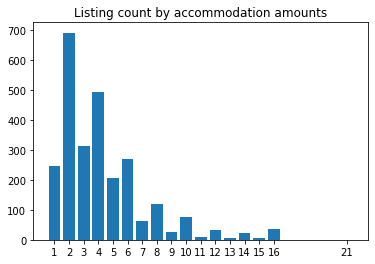

In [7]:
#most common accommodations
df_acc = df_dlist.groupby('accommodates')['accommodates'].count().sort_values(ascending=False)


fig, ax = plt.subplots()
ax.bar(df_acc.index,df_acc)
ax.set_xticks(df_acc.index)
ax.set_title('Listing count by accommodation amounts')
plt.show()

In [8]:
#price distribution
prices_gen = df_list['price']
prices_gen.describe()

count    2624.000000
mean      139.698171
std       134.607059
min        15.000000
25%        60.000000
50%       109.000000
75%       175.000000
max      2000.000000
Name: price, dtype: float64

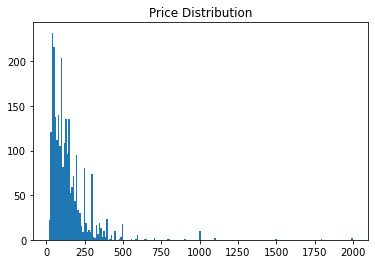

In [9]:
prices_gen.hist(bins=200,grid=False)
plt.title('Price Distribution')
plt.show()

## Exploratory Data Analysis

- ### General exploration with plots

In [10]:
df_num = df_dlist[lst_of_interest]
df_num.fillna(0)

# create the df with numeric value only columns
df_num.loc[:,['price']] = df_num['price'].apply(lambda x: numericalize(x))
df_num.loc[:,['security_deposit']] = df_num['security_deposit'].apply(lambda x: numericalize(x))
df_num.loc[:,['cleaning_fee']] = df_num['cleaning_fee'].apply(lambda x: numericalize(x))
df_num.loc[:,['extra_people']] = df_num['extra_people'].apply(lambda x: numericalize(x))


# generate correlation table
df_corr = df_num.corr()
df_corr

/Users/okugotme/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,price,accommodates,host_listings_count,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm
price,1.000000,0.394357,0.128009,0.243361,0.278251,0.349960,0.165291,0.517476,0.347254,0.098165,0.087633,0.111110,-0.096664,-0.074366
accommodates,0.394357,1.000000,-0.052292,0.362566,0.683060,0.880285,0.116939,0.545743,0.638332,0.095300,0.056132,-0.045242,0.132559,0.214738
host_listings_count,0.128009,-0.052292,1.000000,-0.014270,-0.091315,-0.065865,-0.047036,0.246043,-0.054587,-0.163073,0.058190,0.231518,-0.162567,-0.189478
bathrooms,0.243361,0.362566,-0.014270,1.000000,0.529168,0.369624,0.037645,0.194178,0.282502,0.022636,0.111102,0.042592,-0.010892,0.037010
bedrooms,0.278251,0.683060,-0.091315,0.529168,1.000000,0.675252,0.079405,0.389539,0.476398,0.086898,0.121855,-0.001416,0.026804,0.079670
beds,0.349960,0.880285,-0.065865,0.369624,0.675252,1.000000,0.133672,0.482547,0.623021,0.112936,0.054534,-0.047460,0.098606,0.177534
security_deposit,0.165291,0.116939,-0.047036,0.037645,0.079405,0.133672,1.000000,0.182275,0.097721,0.173396,0.042113,-0.117184,-0.003389,-0.019403
cleaning_fee,0.517476,0.545743,0.246043,0.194178,0.389539,0.482547,0.182275,1.000000,0.458471,0.028762,0.268953,0.103738,-0.137842,-0.099621
guests_included,0.347254,0.638332,-0.054587,0.282502,0.476398,0.623021,0.097721,0.458471,1.000000,0.272911,0.185208,0.004145,0.105145,0.188620
extra_people,0.098165,0.095300,-0.163073,0.022636,0.086898,0.112936,0.173396,0.028762,0.272911,1.000000,-0.060892,-0.037213,0.051934,0.078145


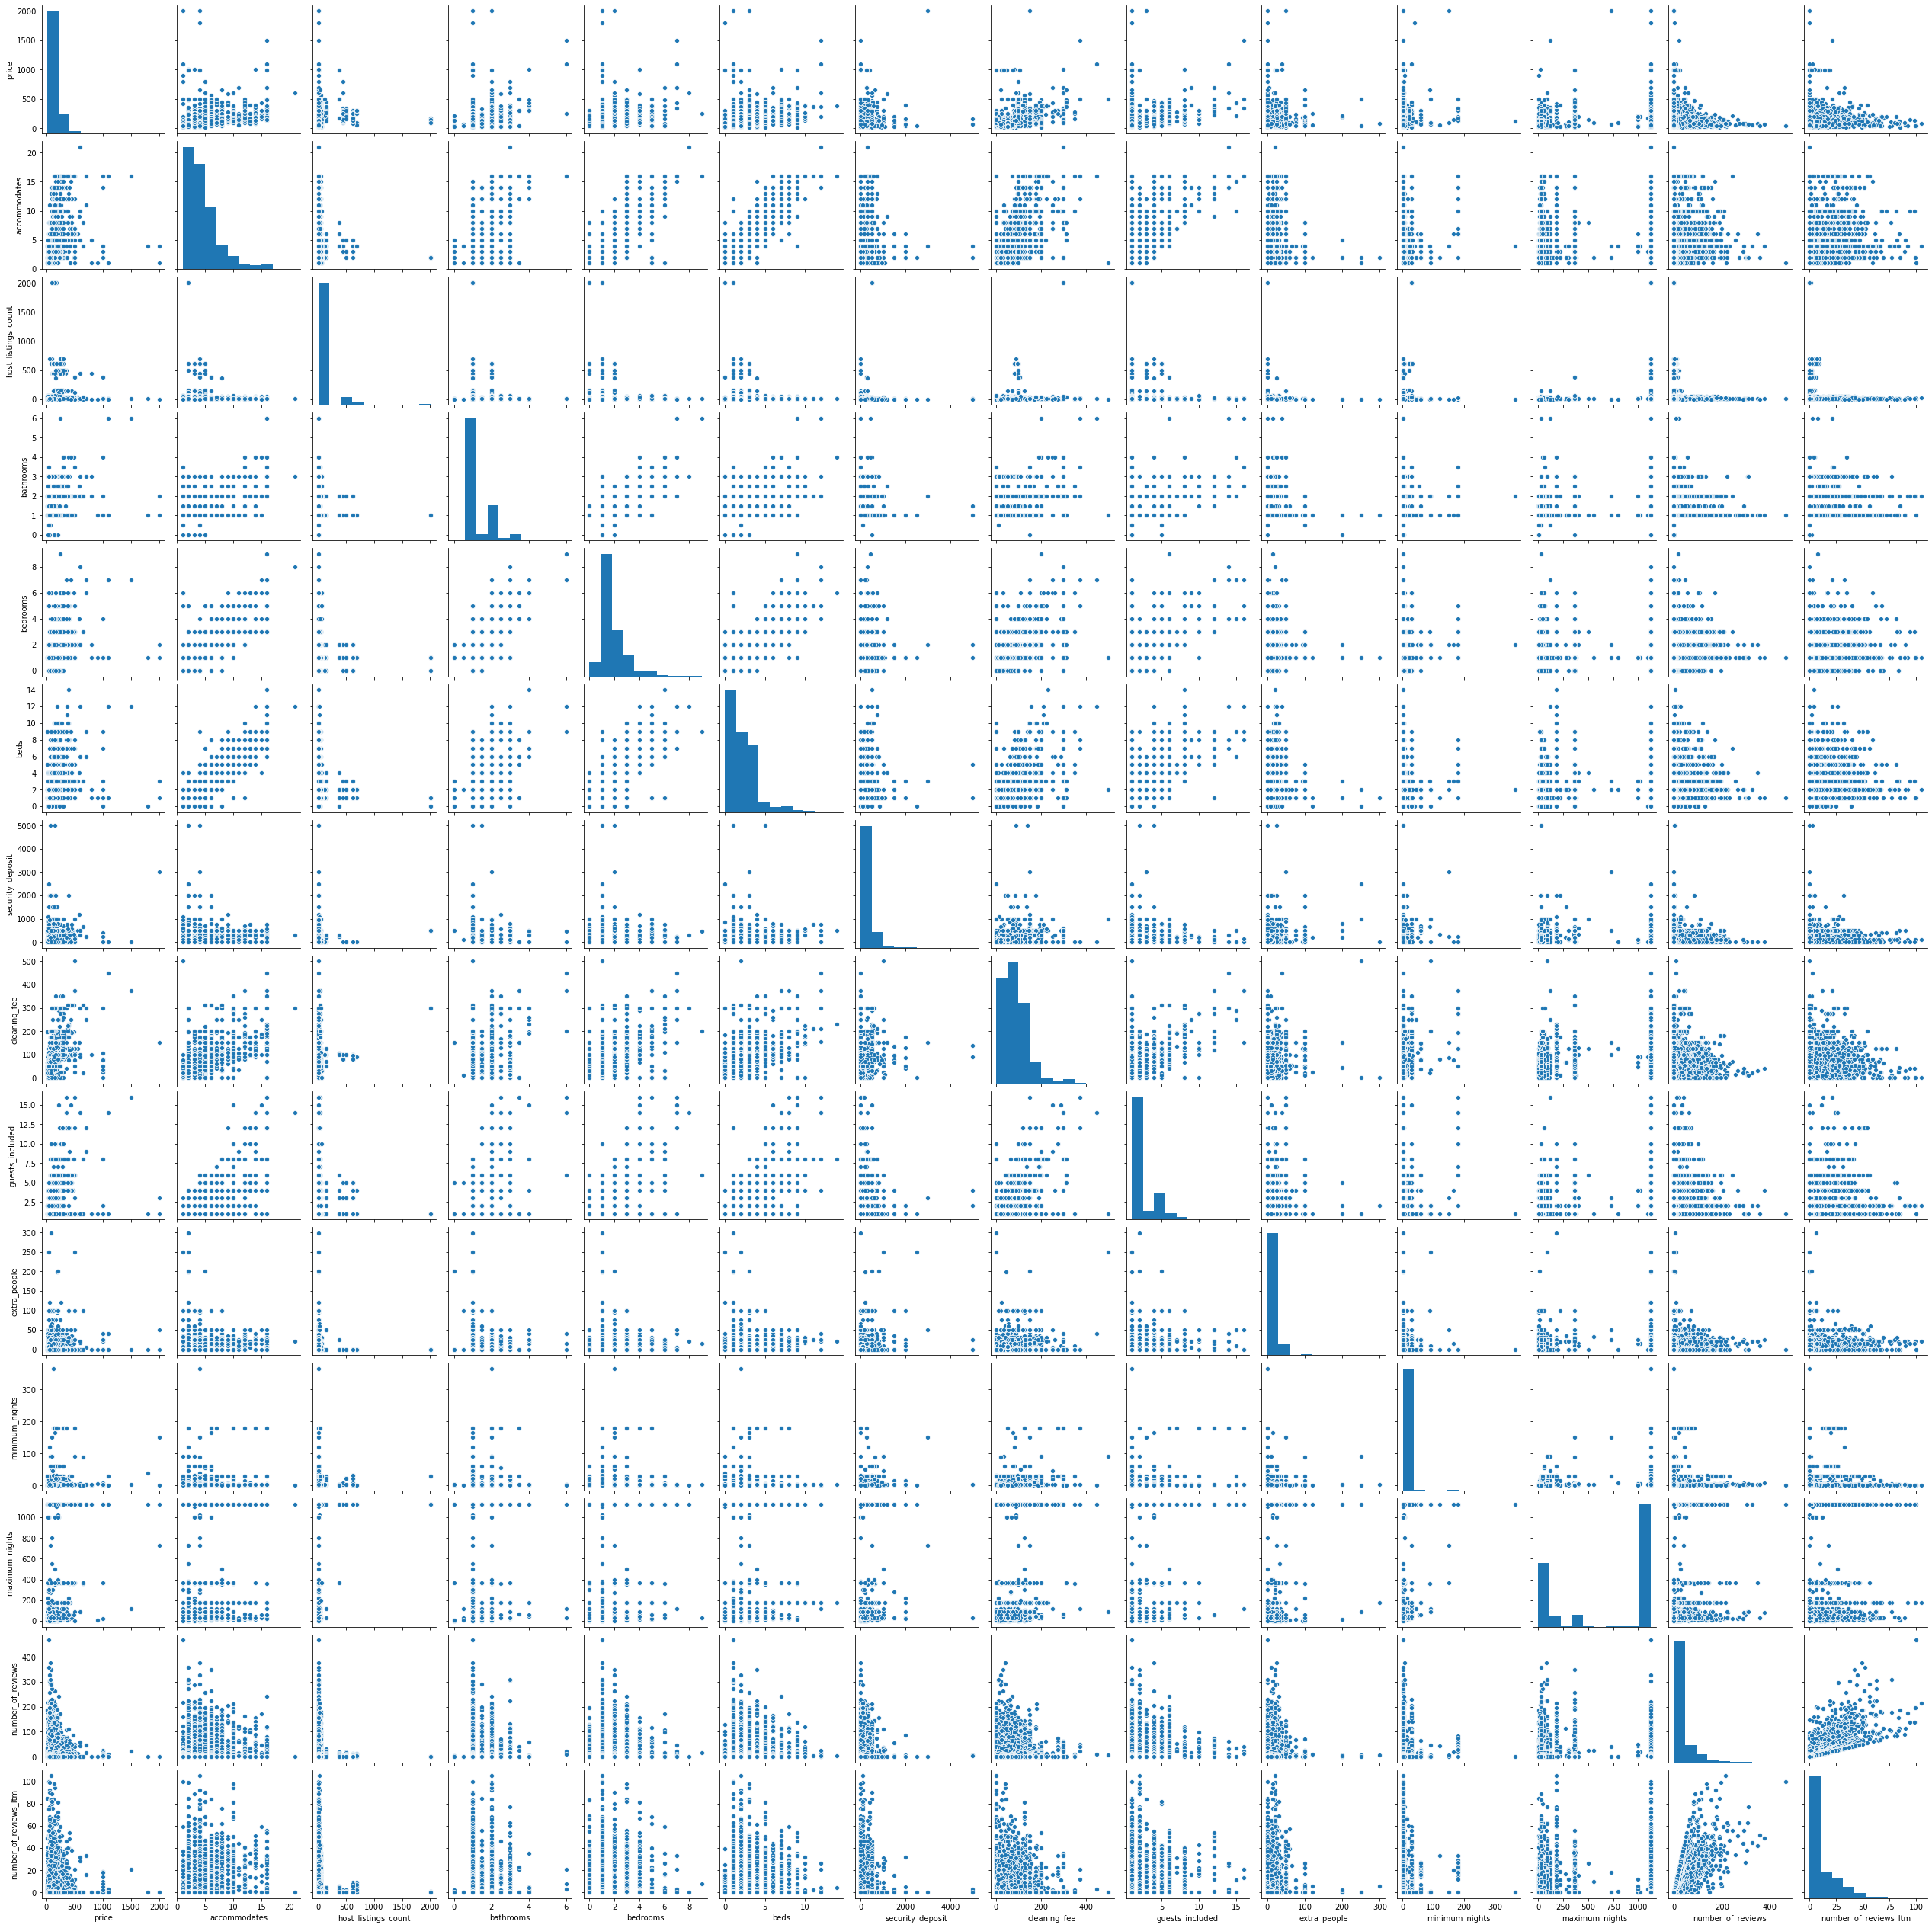

In [11]:
#using the same dataframe to create a scatter plot matrix
g_num = sns.pairplot(df_num)
g_num
plt.show()

- ### Plotting selected pairs with relatively high correlation coefficiency

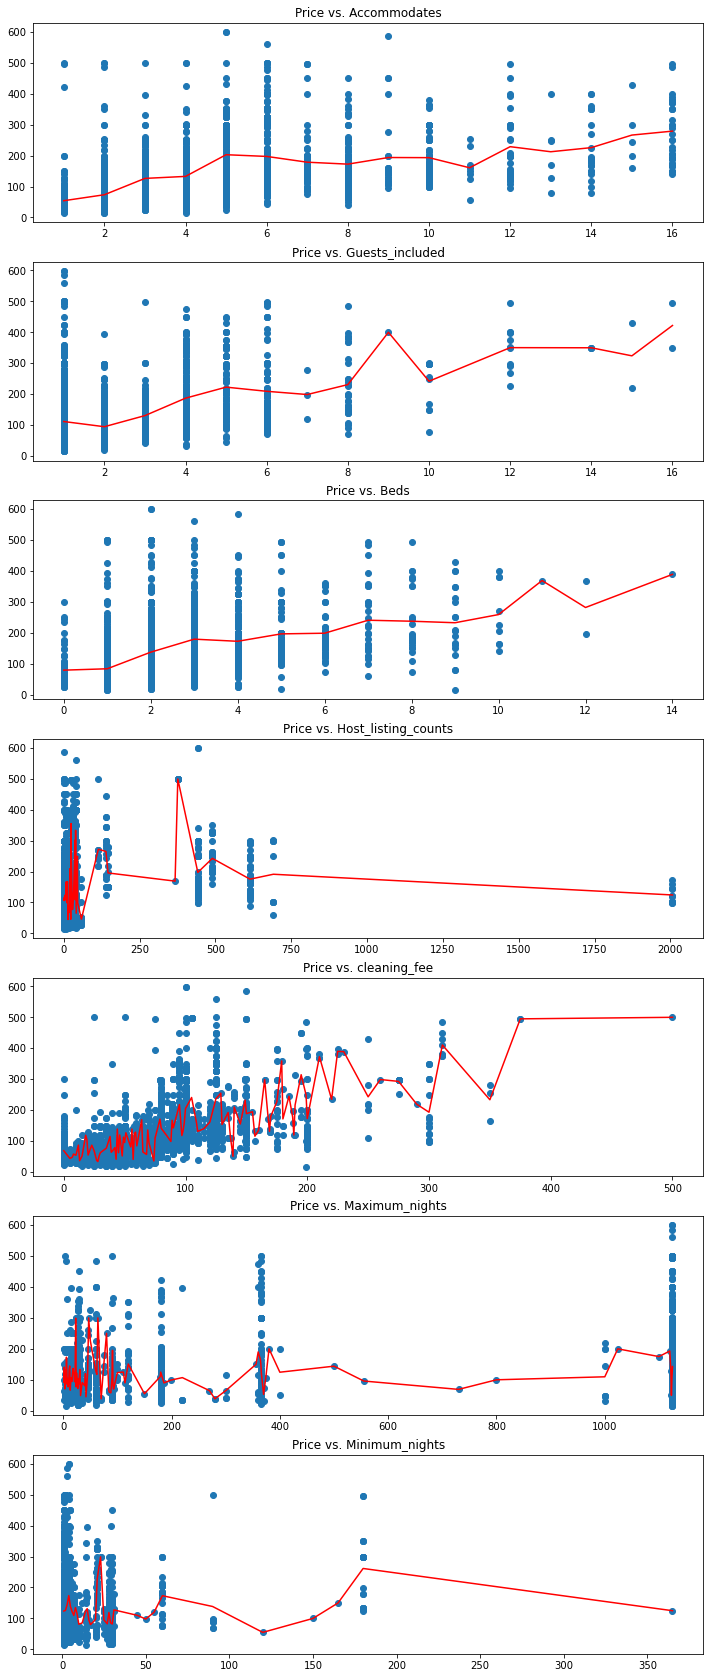

In [12]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,figsize = [12,30])

# eliminate outliers and further filter items of interest
df_num_no = df_num[df_num['price']<600]
to_plot = ['price','accommodates','guests_included','beds',
           'host_listings_count','cleaning_fee','maximum_nights',
           'minimum_nights']

# get adjusted data and the means
adj_, avg_ = get_adj_avg(to_plot,df_num_no)
prices, accommodates, guests, beds, host_lsting_count, clean_fee, max_nights, min_nights = adj_
avg_p, avg_a, avg_g, avg_b, avg_h, avg_c, avg_ma, avg_mi = avg_


# plotting
ax1.scatter(accommodates,prices)
ax1.plot(avg_a.index,avg_a,color='red')
ax1.set_title('Price vs. Accommodates')

ax2.scatter(guests,prices)
ax2.plot(avg_g.index,avg_g, color='red')
ax2.set_title('Price vs. Guests_included')

ax3.scatter(beds,prices)
ax3.plot(avg_b.index,avg_b, color='red')
ax3.set_title('Price vs. Beds')
            
ax4.scatter(host_lsting_count, prices)
ax4.plot(avg_h.index,avg_h, color='red')
ax4.set_title('Price vs. Host_listing_counts')
            
ax5.scatter(clean_fee, prices)
ax5.plot(avg_c.index,avg_c, color='red')
ax5.set_title('Price vs. cleaning_fee')
            
ax6.scatter(max_nights,prices)
ax6.plot(avg_ma.index,avg_ma, color='red')
ax6.set_title('Price vs. Maximum_nights')

ax7.scatter(min_nights, prices)
ax7.plot(avg_mi.index,avg_mi, color='red')
ax7.set_title('Price vs. Minimum_nights')

fig.savefig('comparison plots.png')
plt.show()

- ### Based on the the results, choose price vs. accommodates relationship to create the null hypothesis

        - Null Hypothesis: the amount of people a listing accommodates has no effect on the listing price; 
         the mean of listings that accommodates 2, 4, 6, 8, 10, 12 guests is equal to the mean of all listings.
         
        - Alternative Hypothesis: the amount of people a listing accommodates does affect the listing price; 
         the mean of listings that accommodates 2, 4, 6, 8, 10, 12 guests is NOT equal to the mean of all listings.
         
        - A t-test is used for p-value; alpha = 0.05

count    2597.000000
mean      130.833269
std        94.738304
min        15.000000
25%        60.000000
50%       105.000000
75%       170.000000
max       599.000000
Name: price, dtype: float64

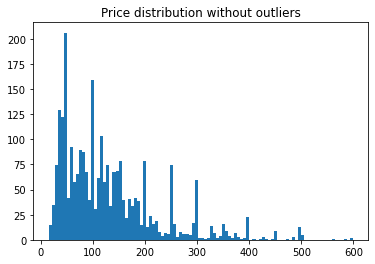

In [13]:
#adjusted price distribution
prices.hist(bins=100, grid=False)
plt.title('Price distribution without outliers')
prices.describe()

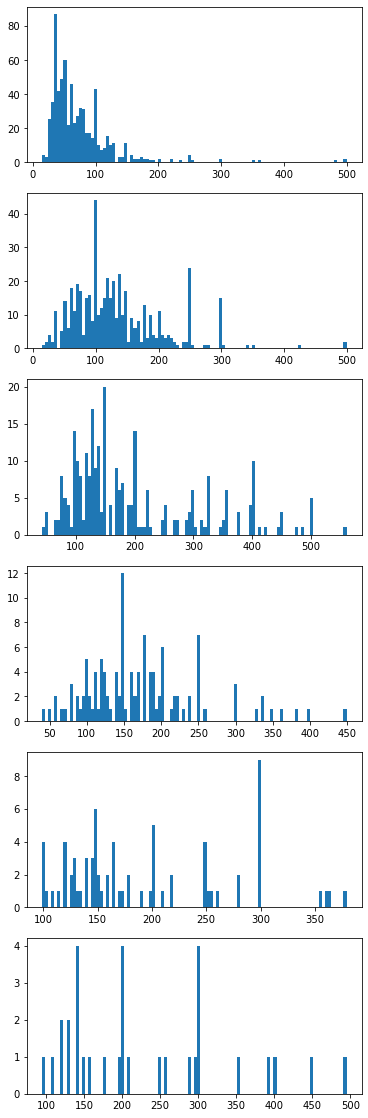

In [14]:
# plot the price distribution for each listing group according to how many people they accommodates
prices_a2 = df_num_no[df_num_no['accommodates'] == 2]['price']
prices_a4 = df_num_no[df_num_no['accommodates'] == 4]['price']
prices_a6 = df_num_no[df_num_no['accommodates'] == 6]['price']
prices_a8 = df_num_no[df_num_no['accommodates'] == 8]['price']
prices_a10 = df_num_no[df_num_no['accommodates'] == 10]['price']
prices_a12 = df_num_no[df_num_no['accommodates'] == 12]['price']
accommodates_groups = [prices_a2,prices_a4,prices_a6,prices_a8,prices_a10,prices_a12]


fig, axes_group = plt.subplots(6, figsize = [6,20])

for price, ax in zip(accommodates_groups, axes_group):
    ax.hist(price, bins=100)

In [15]:
# calculate p_value for each listing group
num = 0
for price in accommodates_groups:
    num += 2
    out = stats.ttest_ind(prices, price)
    print(f'The p-value for listings that accommodates {num} people is: {out[1]}')

The p-value for listings that accommodates 2 people is: 4.215456140376009e-51
The p-value for listings that accommodates 4 people is: 0.6785884568587857
The p-value for listings that accommodates 6 people is: 1.320270303775871e-26
The p-value for listings that accommodates 8 people is: 2.6470892026059196e-06
The p-value for listings that accommodates 10 people is: 1.7173480406858527e-08
The p-value for listings that accommodates 12 people is: 7.479179862356972e-09


- ### Conclusion

        - Based on the p_values, only listing group 4 successfully rejects the null hypothesis and all other groups 
        failed to reject the null hypothesis.
        - Based on the result of this test, we can conclude that the listings that accommodates 4 guests has some 
        effect on the price of the listing. While all other listings don't have enough statistical difference to 
        in the price distribution
        - Drawing from intuition, I think that accommodation capacity does have some, but weak, effect on the 
        listing price. However, our data does not have enough information to show that correlation. 

## Further Studies

- ### Because the result of the t-test could not show strong correlation, additional exploration is required

In [16]:
#listing heatmap
listing_heatmap = folium.Map(location=[40.72613,-74.048110],
                      tiles = 'Stamen Terrain',
                     zoom_start = 13)

listing_heatmap.add_child(MeasureControl())

geo_loc = df_list.iloc[:,6:8]
heat_data = [[row['latitude'],row['longitude']] for dex, row in geo_loc.iterrows()]
HeatMap(heat_data, radius=15,blur=15).add_to(listing_heatmap)

listing_heatmap

In [35]:
#make choropleth map

geo_locs = geopandas.read_file('research/neighbourhoods.geojson')
df_geo = df_dlist[['neighbourhood_cleansed','price']]
df_geo['price'] = df_geo['price'].apply(lambda x: numericalize(x))
geo_mean = df_geo.groupby('neighbourhood_cleansed').mean().reset_index()

geo_locs.dropna(inplace=True,axis=1)

map_geo = folium.Map(location=[40.72613,-74.048110],
                     zoom_start = 13,
                    tiles='Stamen Terrain')

map_geo.choropleth(
    geo_data = geo_locs,
    data = geo_mean,
    columns = ['neighbourhood_cleansed','price'],
    key_on = 'feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2
    )

map_geo

/Users/okugotme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
#average price for each neighbourhood
geo_mean

,neighbourhood_cleansed,price
0,Ward A (councilmember Denise Ridley),97.385321
1,Ward B (councilmember Mira Prinz-Arey),108.273148
2,Ward C (councilmember Richard Boggiano),105.610586
3,Ward D (councilmember Michael Yun),118.316159
4,Ward E (councilmember James Solomon),190.510490
5,Ward F (councilmember Jermaine D. Robinson),103.155425


- ### Introduce coordinates of PATH train stations in Jersey City as additional data for analysis

In [26]:
# coordinates of PATH train stations
df_patht = pd.DataFrame([[40.716765, -74.032380],[40.720421, -74.043038],
                         [40.733400, -74.063824],[40.735377, -74.029272]],
                       index = ['Exchange Place','Grove St','Journal Square','Hoboken'],
                       columns = ['latitude','longitude'])

# create a new dataframe with price and coordinates
# clean the data
df_to_path = df_dlist[['price','latitude','longitude']]
df_to_path['price']= df_to_path['price'].apply(lambda x: numericalize(x))

# find the distance to nearest station
def find_shortest(coor):
    lst = [geopy.distance.geodesic(coor, df_patht.loc[x]).m for x in df_patht.index]
    return min(lst)
        
#find the distance to the nearest PATH station for each listing
df_to_path['to_path']= df_to_path.apply(lambda row: find_shortest([row[1], row[2]]), axis=1)

#eliminate outliers
df_to_path_no = df_to_path[df_to_path['price']<600]

df_to_path_no['to_path'].describe()

/Users/okugotme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/okugotme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    2597.000000
mean     1262.358289
std      1037.079034
min         7.242312
25%       513.536978
50%       831.333654
75%      1876.513675
max      5795.286040
Name: to_path, dtype: float64

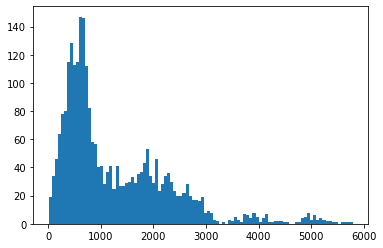

In [33]:
plt.hist(df_to_path_no['to_path'], bins = 100)
plt.show()

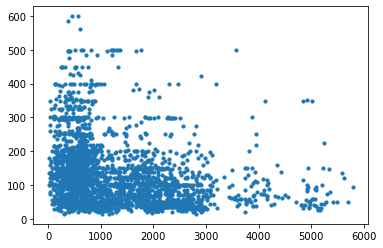

In [28]:
plt.scatter(df_to_path_no['to_path'],df_to_path_no['price'], s= 10)
plt.show()

- ### A stronger correlation between the distance to nearest station and listing price

        - Next step: apply hypothesis testing
        - Gather more location data and population data for further research